### Manipulator PID control

In [1]:
import time
import numpy as np
np.set_printoptions(precision=2)
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
from mujoco_parser import MuJoCoManipulatorParserClass
from pid import PID_ControllerClass
from util import TicTocClass
print ("Done.")

Done.


### Parse manipulator

In [2]:
env = MuJoCoManipulatorParserClass(
    name='Panda',rel_path='../asset/panda/franka_panda.xml',ee_name='panda_eef',VERBOSE=False)
env.init_viewer(TERMINATE_GLFW=True,window_width=0.5,window_height=0.5)

PID = PID_ControllerClass(
    name = 'PID',dim = env.n_rev_joint,
    k_p = 500.0, k_i = 0.0, k_d = 100.0, # <= D gain is super important
    out_min = env.torque_range[env.rev_joint_idxs,0],
    out_max = env.torque_range[env.rev_joint_idxs,1])

q_des = np.array([0,0,0,-90,0,90,0])*np.pi/180.0 # desired position

max_sec  = 5.0
max_tick = int(max_sec*env.HZ)+1
q_curr_list  = np.zeros(shape=(max_tick,PID.dim))
q_des_list   = np.zeros(shape=(max_tick,PID.dim))
sec_sim_list = np.zeros(shape=(max_tick))
torque_list  = np.zeros(shape=(max_tick,PID.dim))

env.reset() # reset env
PID.reset() # reset PID
while True:

    # Control revolute joint
    PID.update(x_trgt=q_des)
    PID.update(t_curr=env.sec_sim,x_curr=env.q_curr,VERBOSE=False)
    torque = PID.out()
    
    # Step and render
    env.step_and_render(torque=torque,render_speedup=2.0)
    env.print(print_every_sec=1.0,VERBOSE=1)
    
    # Append current and target joint positions
    q_curr_list[env.tick-1,:],sec_sim_list[env.tick-1] = env.q_curr,env.sec_sim
    q_des_list[env.tick-1,:],torque_list[env.tick-1,:] = q_des,torque
    
    # Terminate
    if env.tick >= max_tick: break
print ("Done.")

Creating window glfw
tick:[1], sec_wall:[0.000]sec, sec_sim:[0.000]sec
tick:[501], sec_wall:[0.501]sec, sec_sim:[1.000]sec
tick:[1001], sec_wall:[0.998]sec, sec_sim:[2.000]sec
tick:[1501], sec_wall:[1.506]sec, sec_sim:[3.000]sec
tick:[2001], sec_wall:[1.994]sec, sec_sim:[4.000]sec
tick:[2501], sec_wall:[2.502]sec, sec_sim:[5.000]sec
Done.


In [3]:
env.terminate_viewer() # terminate viewer

### Plot joint tracking results

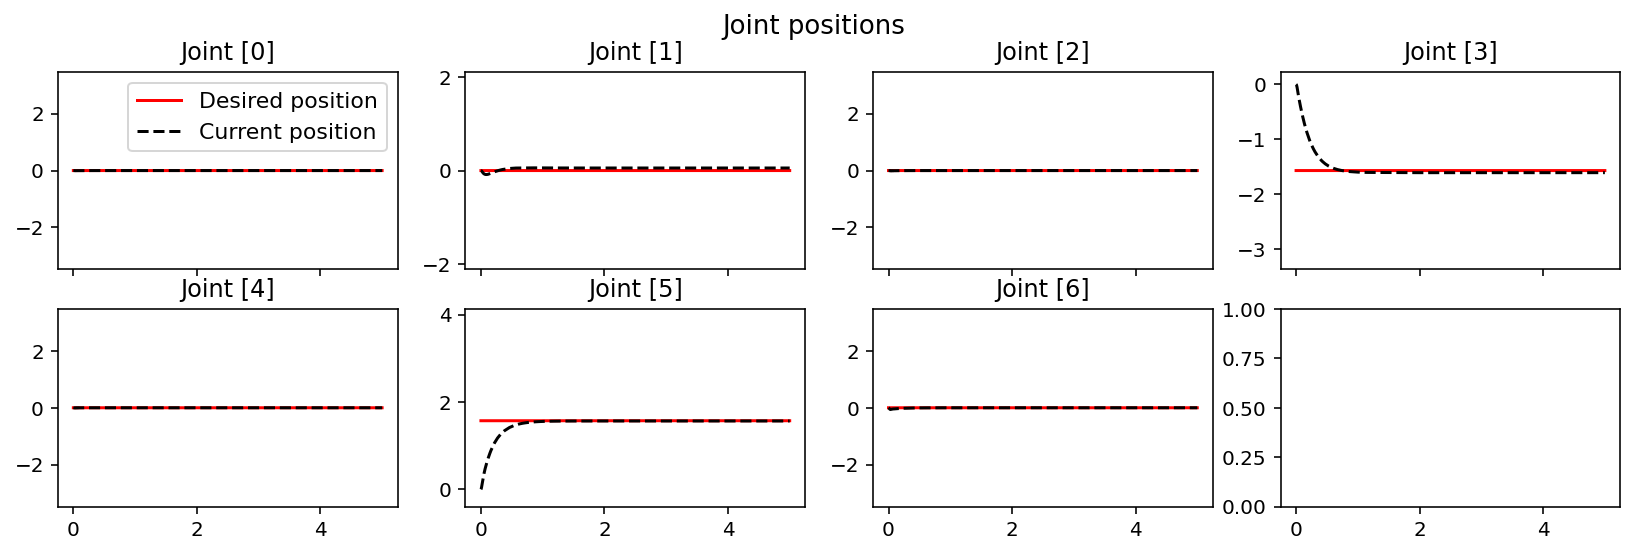

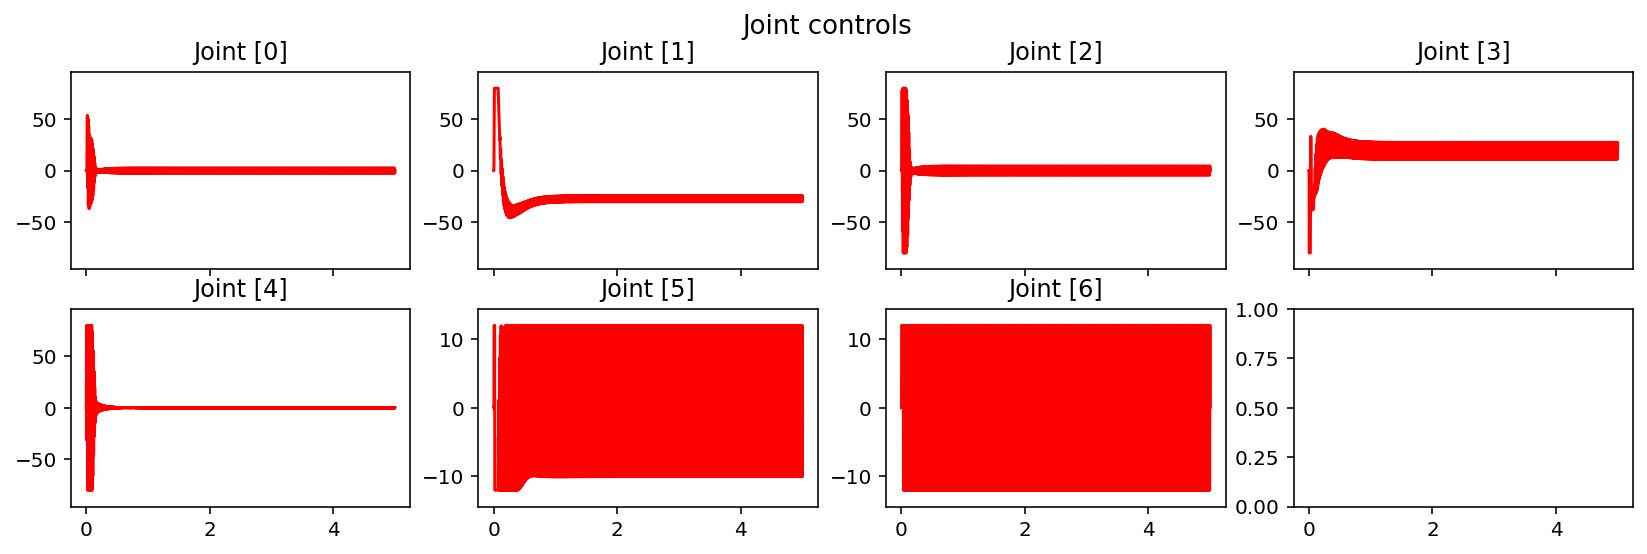

In [4]:
# Plot target and current joint position
fig,axs = plt.subplots(nrows=2,ncols=4,sharex=True,sharey=False,figsize=(14,4))
fig.suptitle("Joint positions", fontsize=13)
for a_idx,ax in enumerate(axs.ravel()):
    if (a_idx >= PID.dim): continue
    ax.plot(sec_sim_list,q_des_list[:,a_idx],'-',color='r',label='Desired position')
    ax.plot(sec_sim_list,q_curr_list[:,a_idx],'--',color='k',label='Current position')
    qmarg = 0.1*(env.joint_range[a_idx,1]-env.joint_range[a_idx,0])
    ax.set_ylim(bottom=env.joint_range[a_idx,0]-qmarg,top=env.joint_range[a_idx,1]+qmarg)
    ax.set_title('Joint [%d]'%(a_idx))
    if a_idx == 0: ax.legend(fontsize=11)
plt.show()
# Plot control output
fig,axs = plt.subplots(nrows=2,ncols=4,sharex=True,sharey=False,figsize=(14,4))
fig.suptitle("Joint controls", fontsize=13)
for a_idx,ax in enumerate(axs.ravel()):
    if (a_idx >= PID.dim): continue
    ax.plot(sec_sim_list,torque_list[:,a_idx],color='r')
    tmarg = 0.1*(env.torque_range[a_idx,1]-env.torque_range[a_idx,0])
    ax.set_ylim(bottom=env.torque_range[a_idx,0]-tmarg,top=env.torque_range[a_idx,1]+tmarg)
    ax.set_title('Joint [%d]'%(a_idx))
plt.show()